In [1]:
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import re
from tqdm import tqdm

import random

from copy import deepcopy

In [2]:
dummy_maze = [
              [ "", "", "", "", "", "", "", ""],
              [ "", "", "", "", "", "", "", ""],
              [ "#", "#", "#", "#", "#", "", "", ""],
              [ "", "", "", "", "", "", "", ""],
              [ "", "", "#", "#", "#", "#", "#", ""],
              [ "", "", "#", "", "", "", "", ""],
              [ "", "", "#", "", "#", "#", "#", "#"],
              [ "", "", "", "", "", "", "", ""],
        ]

reward_matrix = [
          [ -1, -1, -1, -1, -1, -1, -1, -1],
          [ -1, -1, -1, -1, -1, -1, -1, -1],
          [ -10000, -10000, -10000, -10000, -10000, -1, -1, -1],
          [ -1, -1, -1, -1, -1, -1, -1, -1],
          [ -1, -1, -10000, -10000, -10000, -10000, -10000, -1],
          [ -1, -1, -10000, -1, -1, -1, -1, -1],
          [ -1, -1, -10000, -1, -10000, -10000, -10000, -10000],
          [ -1, -1, -1, -1, -1, -1, -1, 0]
        ]

In [3]:
class MDPState:
    def __init__(self, up, down, left, right, reward=-1):
        self.up = up
        self.down = down
        self.left = left
        self.right = right
        self.reward = reward
        self.q_values = ActionQValue()


class ActionQValue:
    def __init__(self, up=0, down=0, left=0, right=0):
        self.up = up
        self.down = down
        self.left = left
        self.right = right

In [5]:
# number of episode we will run
n_episodes = 10000

# maximum of iteration per episode
max_iter_episode = 100

# initialize the exploration probability to 1
exploration_proba = 1

# exploration decreasing decay for exponential decreasing
exploration_decreasing_decay = 0.001

# minimum of exploration proba
min_exploration_proba = 0.01

# discounted factor
gamma = 0.90

# learning rate
lr = 0.1

start_state = (0, 0)
end_state = (7, 7)
# Actions
actions = ['up', 'down', 'left', 'right']


def get_max_action(grid, state):
    q = []
    for a in actions:
        q.append(getattr(grid[state[0]][state[1]].q_values, a))
    action = actions[q.index(max(q))]
    return action


def get_max_q_value(grid, state):
    q = []
    for a in actions:
        q.append(getattr(grid[state[0]][state[1]].q_values, a))
    return max(q)


def q_learning(grid, iterations=6000):

    global exploration_proba
    rewards_per_episode = []
    delta = []
    for e in tqdm(range(iterations)):
        biggest_change = 0
        current_state = start_state

        # sum the rewards that the agent gets from the environment
        total_episode_reward = 0

        for i in range(max_iter_episode):

            if np.random.uniform(0, 1) < exploration_proba:
                action = random.choice(actions)
            else:
                action = get_max_action(grid, current_state)

            next_state = getattr(grid[current_state[0]][current_state[1]], action)
#             reward = grid[current_state[0]][current_state[1]].reward
            reward = reward_matrix[current_state[0]][current_state[1]]
#             print(reward)
            

            # We update our Q-table using the Q-learning iteration
            new_q_value = (1 - lr) * getattr(grid[current_state[0]][current_state[1]].q_values, action) + lr * (
                    reward + gamma * get_max_q_value(grid, next_state))
            
            biggest_change = max(biggest_change, np.abs(getattr(grid[current_state[0]][current_state[1]].q_values, action) - new_q_value))
            delta.append(biggest_change)
            
            setattr(grid[current_state[0]][current_state[1]].q_values, action, new_q_value)

            total_episode_reward = total_episode_reward + reward
            # If the episode is finished, we leave the for loop
            if grid[next_state[0]][next_state[1]] == "#":
                break
            current_state = next_state
        exploration_proba = max(min_exploration_proba, np.exp(-exploration_decreasing_decay * e))
        rewards_per_episode.append(total_episode_reward)

    policy = [['up' for i in range(len(grid[0]))] for j in range(len(grid))]
    optimal_q_values = []
    for i in range(len(grid)):
        _values = []
        for j in range(len(grid[i])):
            if grid[i][j] != '#':
                policy[i][j] = get_max_action(grid, (i, j))
                _values.append(get_max_q_value(grid, (i, j)))

            else:
                policy[i][j] = '#'
                _values.append(0)
        optimal_q_values.append(_values)
    return policy, optimal_q_values, rewards_per_episode, delta


def maze_to_mdp(matrix):
    
    grid = deepcopy(matrix)
    for i in range(0, len(matrix)):
        for j in range(0, len(matrix)):
            # represent walls as #
            if matrix[i][j] == '#':
                grid[i][j] = "#"
                continue
                
            try:
                if i ==0:
                    north = (i,j)
                elif matrix[i - 1][j] == '#':
                    north = (i, j)
                else:
                    north = (i - 1, j)
            except:
                pass
            
            try:
                if i == len(matrix)-1:
                    south = (i,j)
                elif matrix[i + 1][j] == '#':
                    south = (i, j)
                else:
                    south = (i + 1, j)
            except:
                pass
            
            try:
                if j == len(matrix)-1:
                    east = (i,j)
                elif matrix[i][j + 1] == '#':
                    east = (i, j)
                else:
                    east = (i, j + 1)
            except:
                pass
            
            try:
                if j ==0:
                    west = (i,j)
                elif matrix[i][j - 1] == '#':
                    west = (i, j)
                else:
                    west = (i, j - 1)
            except:
                pass

            grid[i][j] = MDPState(north, south, west, east)

    # Set exit point reward
    grid[7][7].reward = 0
    return (grid)

def get_shortest_path(policy, start, end):
    shortest_path = [start]
    i, j = start
    while True:
        action = policy[i][j]
        if action == "down":
            i += 1
        if action == "up":
            i -= 1
        if action == "left":
            j -= 1
        if action == "right":
            j += 1
        if (i, j) == end:
            shortest_path.append(end)
            break
        else:
            shortest_path.append((i, j))
    return shortest_path

In [58]:
test_grid = maze_to_mdp(dummy_maze)
q_learning_policy, optimal_q_values, q_learning_rewards_per_episode, delta = q_learning(test_grid, 10000)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1003.96it/s]


In [7]:
q_path = get_shortest_path(q_learning_policy, (0,0), (7,7))
print("Shortest path Using Q learning", q_path, "number of nodes present in shortest path is ", len(q_path))

Shortest path Using Q learning [(0, 0), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 5), (3, 5), (3, 4), (3, 3), (3, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7)] number of nodes present in shortest path is  23


Text(0.5, 1.0, 'Optimal values for policy iteration')

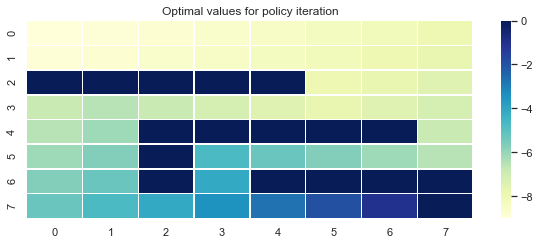

In [8]:
plt.rcParams["figure.figsize"] = (10,8)
plt.grid(color='r', linestyle='-', linewidth=.5)
plt.subplot(2, 1, 1)
sns.heatmap(optimal_q_values, cmap="YlGnBu", linewidths=.5)
plt.title("Optimal values for policy iteration")

In [9]:
q_learning_policy

[['down', 'down', 'down', 'down', 'down', 'down', 'right', 'down'],
 ['right', 'right', 'right', 'right', 'right', 'down', 'down', 'down'],
 ['#', '#', '#', '#', '#', 'down', 'down', 'down'],
 ['right', 'down', 'left', 'left', 'left', 'left', 'right', 'down'],
 ['down', 'down', '#', '#', '#', '#', '#', 'down'],
 ['down', 'down', '#', 'down', 'left', 'left', 'left', 'left'],
 ['right', 'down', '#', 'down', '#', '#', '#', '#'],
 ['right', 'right', 'right', 'right', 'right', 'right', 'right', 'up']]

In [10]:
m1 = [[0 for i in range(8)] for i in range(8)]

blocked = [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 2), (6, 2), (6, 4), (6, 5), (6, 6), (6, 7)]
for q in q_path:
    m1[q[0]][q[1]]=1

for b in blocked:
    m1[b[0]][b[1]] = -1

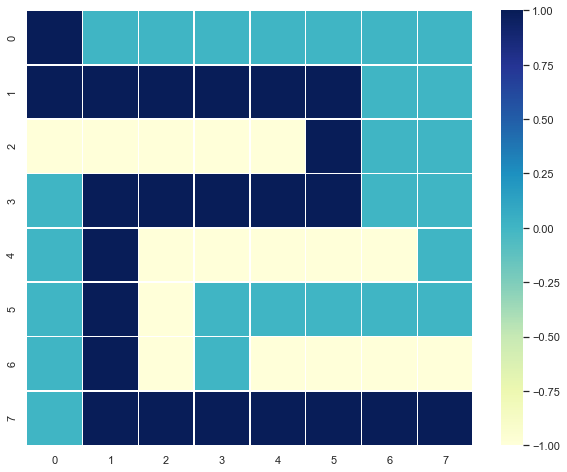

In [11]:
fig, axs = plt.subplots(figsize=(10,8))
axs = sns.heatmap(m1, cmap="YlGnBu", linewidths=.5, ax=axs)
plt.show()

In [12]:
m2 = [[0 for i in range(8)] for i in range(8)]

blocked = [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 2), (6, 2), (6, 4), (6, 5), (6, 6), (6, 7)]
# for q in q_path:
#     m1[q[0]][q[1]]=1

for b in blocked:
    m2[b[0]][b[1]] = -10000

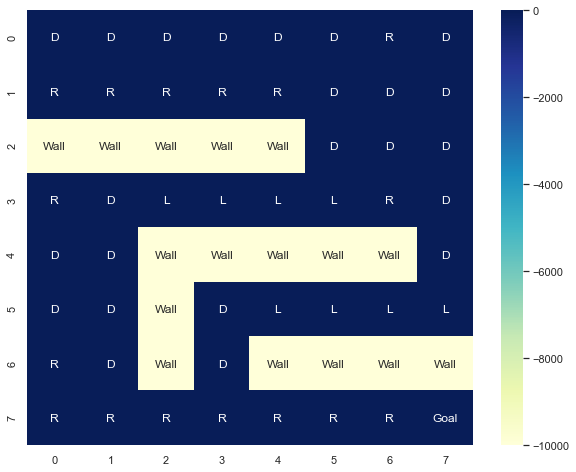

In [16]:
fig, axs = plt.subplots(figsize=(10,8))
axs = sns.heatmap(m2, cmap="YlGnBu", ax=axs, annot=np.array(m3), fmt="")
plt.show()

In [14]:
m3 = q_learning_policy

In [15]:
for i in range(len(m3)):
    for j in range(len(m3)):
        if m3[i][j]=="down":
            m3[i][j]="D"
        elif m3[i][j]=="up":
            m3[i][j]="Goal"
        elif m3[i][j]=="right":
            m3[i][j]="R"
        elif m3[i][j]=="left":
            m3[i][j]="L"
        else:
            m3[i][j]="Wall"

In [68]:
from sklearn import preprocessing
q_delta_norm = preprocessing.normalize([delta])

In [69]:
n=100
q_delta_rew = [sum(q_delta_norm[0][i:i+25*n])/25*n for i in range(0,len(q_delta_norm[0]),25*n)]

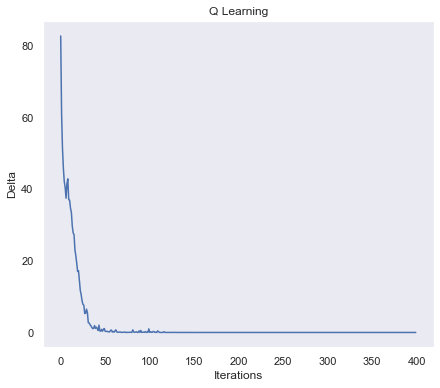

In [70]:
fig, ax1 = plt.subplots(ncols=1, figsize=(7,6))
ax1.plot(q_delta_rew)
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Delta")
ax1.set_title("Q Learning")
ax1.grid(False)
ax.set_facecolor('white')
# ax.set_axis_bgcolor('white')
plt.show()

In [71]:
pd.DataFrame(q_delta_rew).to_csv("qdelta.csv")